# Explore the Dallas Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, csv, bz2, collections, datetime, sys
import geopandas as gpd
import pandas as pd
import numpy as np
import tilemapbase
import shapely.geometry
import pyproj
proj = pyproj.Proj({"init":"EPSG:2845"})

In [2]:
#datadir = os.path.join("..", "..", "..", "Data")
datadir = os.path.join("/media", "disk", "Data")
filename = os.path.join(datadir, "Dallas_11_Sept_2017.csv")

def gen():
    with open(filename, "rt", encoding="UTF8") as f:
        reader = csv.reader(f)
        yield from reader

There is a _huge_ amount of data, only a small fraction which we wish to use.

In [3]:
next(gen())

['Incident Number w/ Year',
 'Year of Incident',
 'Incident Number wo/ Year',
 'Offense Service Number',
 'Service Number ID',
 'Watch',
 'Call (911) Problem',
 'Type of Incident',
 'Penalty Class',
 'Type of Location',
 'Type of Property',
 'Street Block',
 'Street Direction',
 'Street Name',
 'Incident Address',
 'Apartment Number',
 'Zip Code',
 'City',
 'State',
 ' X Coordinate ',
 ' Y Coordinate',
 'Reporting Area',
 'Beat',
 'Division',
 'Sector',
 'Council District',
 'Target Area Action Grids',
 'Community',
 'Date1 of Occurrence',
 'Year1 of Occurrence',
 'Month1 of Occurence',
 'Day1 of the Week',
 'Time1 of Occurrence',
 'Day1 of the Year',
 'Date2 of Occurrence',
 'Year2 of Occurrence',
 'Month2 of Occurence',
 'Day2 of the Week',
 'Time2 of Occurrence',
 'Day2 of the Year',
 'Starting  Date/Time',
 'Ending Date/Time',
 'Map Date',
 'Date of Report',
 'Date incident created',
 'Offense Entered Year',
 'Offense Entered Month',
 'Offense Entered Day of the Week',
 'Offense En

In [4]:
rows = gen()
header = next(rows)
frame = {i:[] for i,_ in enumerate(header)}
for row in rows:
    assert len(row) == len(header)
    for i, e in enumerate(row):
        frame[i].append(e)
frame = {key:frame[i] for i, key in enumerate(header)}
frame = pd.DataFrame(frame)
frame.head()

,X Coordinate,Y Coordinate,Apartment Number,Assisting Officer Badge No,Beat,CJIS Code,Call (911) Problem,Call Cleared Date Time,Call Date Time,Call Dispatch Date Time,...,Victim Condition,Victim Injury Description,Victim Package,Watch,Weather,Year Assignment,Year of Incident,Year1 of Occurrence,Year2 of Occurrence,Zip Code
0,2487549.90103337,7034119.57307657,102,9335,632,22990002,11R - BURG OF RES,11/18/2016 04:54:43 PM,11/18/2016 11:42:26 AM,11/18/2016 04:00:55 PM,...,,,,U,,D,2016,2016,2016,75254
1,2463017.56365858,6959380.81896243,,7397,431,54010010,7X - MAJOR ACCIDENT,11/20/2016 02:58:27 AM,11/20/2016 12:50:30 AM,11/20/2016 01:14:26 AM,...,,,,1,,D,2016,2016,2016,75211
2,2486253.9031726,6963074.89714562,,,411,99999999,55 - TRAFFIC STOP,11/19/2016 05:45:16 AM,11/18/2016 11:28:52 PM,11/18/2016 11:28:53 PM,...,,,,3,,D,2016,2016,2016,75203
3,2473146.04871775,6970274.82913205,102,9051,422,12990002,20 - ROBBERY,11/18/2016 10:29:51 PM,11/18/2016 06:44:57 PM,11/18/2016 06:49:59 PM,...,,,,3,,D,2016,2016,2016,75212
4,2489699.74761609,6975953.20702747,332,8429,122,23990004,PSE/09 - THEFT,11/19/2016 02:57:36 PM,11/19/2016 02:08:16 PM,11/19/2016 02:47:48 PM,...,,,,1,,D,2016,2016,2016,75201


In [5]:
list(frame.columns)

[' X Coordinate ',
 ' Y Coordinate',
 'Apartment Number',
 'Assisting Officer Badge No',
 'Beat',
 'CJIS Code',
 'Call (911) Problem',
 'Call Cleared Date Time',
 'Call Date Time',
 'Call Dispatch Date Time',
 'Call Received Date Time',
 'City',
 'Community',
 'Complainant Age',
 'Complainant Age at Offense',
 'Complainant Apartment',
 'Complainant Business Address',
 'Complainant Business Name',
 'Complainant City',
 'Complainant Gender',
 'Complainant Home Address',
 'Complainant Name',
 'Complainant Race',
 'Complainant State',
 'Complainant Zip Code',
 'Council District',
 'DPDSworn/Marshalls involved',
 'Date incident created',
 'Date of Report',
 'Date1 of Occurrence',
 'Date2 of Occurrence',
 'Day1 of the Week',
 'Day1 of the Year',
 'Day2 of the Week',
 'Day2 of the Year',
 'Division',
 'Drug Related Incident',
 'Element Number Assigned',
 'Ending Date/Time',
 'Family Offense',
 'Final UCR',
 'Gang Related Offense',
 'Hate Crime',
 'Incident Address',
 'Incident Number w/ Year'

# Id numbers

Glad I looked at this, as it shows there are a _lot_ of repeats.  The example below gives a good indication as to why.

In [6]:
frame[['Incident Number w/ Year', 'Year of Incident', 'Incident Number wo/ Year']]
for _, row in frame.iterrows():
    num = row['Incident Number wo/ Year']
    assert num != ""
    year = row['Year of Incident']
    assert "{}-{}".format(num, year) == row['Incident Number w/ Year'].replace(" ", "")
    parts = row["Service Number ID"].replace(" ", "").split("-")
    assert parts[0] == num
    assert parts[1] == year
    int(parts[2])

In [7]:
out = collections.defaultdict(list)
for _, row in frame.iterrows():
    num = row['Incident Number w/ Year']
    parts = row["Service Number ID"].replace(" ", "").split("-")
    out[num].append(int(parts[2]))

In [8]:
for k, v in out.items():
    assert len(v) == len(set(v))
    x = list(v)
    x.sort()
    assert x == list(range(1, len(x)+1))

In [9]:
# Location does not change
out = collections.defaultdict(list)
for _, row in frame.iterrows():
    num = row['Incident Number w/ Year']
    loc = row[' X Coordinate '], row[' Y Coordinate']
    out[num].append(loc)
out = {k : { pt for pt in xy if pt[0]!="" } for k,xy in out.items()}
{k:v for k,v in out.items() if len(v)>1}

{}

In [10]:
# Call time does not change
out = collections.defaultdict(list)
for _, row in frame.iterrows():
    num = row['Incident Number w/ Year']
    out[num].append(row["Call Date Time"])
out = {k : { pt for pt in xy if pt!="" } for k,xy in out.items()}
{k:v for k,v in out.items() if len(v)>1}

{}

In [11]:
out = collections.defaultdict(list)
for _, row in frame.iterrows():
    num = row['Incident Number w/ Year']
    out[num].append(row)
out = {k:v for k,v in out.items() if len(v) > 1}

In [12]:
def rows_really_differ(r1, r2):
    assert list(r1.index) == list(r2.index)
    mask = []
    for k in r1.index:
        mask.append(r1[k] != r2[k] and r1[k] != "" and r2[k] != "")
    return np.asarray(mask)

def difference_frame(k):
    m = rows_really_differ(out[k][0], out[k][1])
    for i in range(2, len(out[k])):
        m |= rows_really_differ(out[k][0], out[k][i])
    return pd.DataFrame(out[k]).T[m]

difference_frame( list(out)[6] )

,59,176,200984
Offense Type,NOT CODED,PART1,NOT CODED
Person Involvement Type,Witness,Victim,Witness
Service Number ID,276294-2015-03,276294-2015-01,276294-2015-02


In [13]:
rows = set()
for k in out:
    rows.update(difference_frame(k).index)
rows

{'CJIS Code',
 'Complainant Age',
 'Complainant Age at Offense',
 'Complainant Apartment',
 'Complainant Business Address',
 'Complainant Business Name',
 'Complainant City',
 'Complainant Gender',
 'Complainant Home Address',
 'Complainant Name',
 'Complainant Race',
 'Complainant State',
 'Complainant Zip Code',
 'Drug Related Incident',
 'Final UCR',
 'Gang Related Offense',
 'Modus Operandi (MO)',
 'Offense Code CC',
 'Offense Type',
 'Penal Code',
 'Penalty Class',
 'Person Involvement Type',
 'RMS Code',
 'Service Number ID',
 'Type of Incident',
 'Type of Location',
 'Type of Property',
 'UCR 1',
 'UCR Offense Description',
 'UCR Offense Name',
 'Victim Condition',
 'Victim Injury Description'}

## Crime types

We want to look at `UCR Offense Description` for the headline, and maybe `UCR Offense Name` for a fairly minimal extra amount of information.

In [14]:
out = collections.defaultdict(set)
for i, row in frame.iterrows():
    key = row["UCR Offense Description"]
    out[key].add(row["UCR Offense Name"])
out

defaultdict(set,
            {'': {''},
             "'FRAUD": {'FRAUD'},
             'ACCIDENTAL INJURY': {'INJURED PUBLIC'},
             'AGGRAVATED ASSAULT': {'AGG ASSAULT - NFV'},
             'AIRPLANE': {'OTHERS'},
             'ANIMAL BITE': {'ANIMAL BITE'},
             'ARSON': {'ARSON'},
             'ASSAULT': {'ASSAULT'},
             'AUTO THEFT - UUMV': {'UUMV'},
             'BURGLARY': {'BURGLARY-BUSINESS', 'BURGLARY-RESIDENCE'},
             'CHILD (OFFENSES AGAINST)': {'OFFENSE AGAINST CHILD'},
             'CRIMINAL MISCHIEF/VANDALISM': {'CRIMINAL MISCHIEF/VANDALI',
              'LANDALISM & CRIM MISCHIEF',
              'VANDALISM & CRIM MISCHIEF'},
             'DISORDERLY CONDUCT': {'DISORDERLY CONDUCT'},
             'DWI': {'DWI'},
             'EMBEZZLEMENT': {'EMBEZZLEMENT'},
             'FIREARMS ACCIDENT': {'INJURED FIREARM'},
             'FORGERY & COUNTERFEIT': {'FORGE & COUNTERFEIT'},
             'FOUND PROPERTY': {'FOUND'},
             'FRAUD': {'

In [15]:
out = collections.defaultdict(set)
for i, row in frame.iterrows():
    key = row["UCR Offense Description"]
    out[key].add(row["Offense Type"])
out

defaultdict(set,
            {'': {''},
             "'FRAUD": {'PART2'},
             'ACCIDENTAL INJURY': {'NOT CODED'},
             'AGGRAVATED ASSAULT': {'NOT CODED', 'PART1'},
             'AIRPLANE': {'NOT CODED'},
             'ANIMAL BITE': {'PART2'},
             'ARSON': {'Part2'},
             'ASSAULT': {'Part2'},
             'AUTO THEFT - UUMV': {'NOT CODED', 'PART1'},
             'BURGLARY': {'NOT CODED', 'PART1'},
             'CHILD (OFFENSES AGAINST)': {'PART2'},
             'CRIMINAL MISCHIEF/VANDALISM': {'PART2'},
             'DISORDERLY CONDUCT': {'PART2'},
             'DWI': {'PART2'},
             'EMBEZZLEMENT': {'PART2'},
             'FIREARMS ACCIDENT': {'NOT CODED'},
             'FORGERY & COUNTERFEIT': {'PART2'},
             'FOUND PROPERTY': {'NOT CODED'},
             'FRAUD': {'PART2'},
             'GAMBLING': {'PART2'},
             'HOME ACCIDENT': {'NOT CODED'},
             'INTOXICATION MANSLAUGHTER': {'PART2'},
             'LIQUOR': {'PART

# Check time data

We can assemble the start time from:

    Date1 of Occurrence
    Year1 of Occurrence
    Month1 of Occurence
    Day1 of the Week
    Time1 of Occurrence
    Day1 of the Year

These appear to agree exactly.

and for "2".  Should compare against:

    Starting  Date/Time
    Ending Date/Time

#### Conclude

The dates are very consistent, and it's fine just to use `Starting  Date/Time` and `Ending Date/Time`.  **Exception:** The _ordering_ of the start/end can be wrong!

In [6]:
def to_date(num, row):
    """Returns (year, month, string_day, day_of_year)"""
    return (int(row["Year{} of Occurrence".format(num)]), 
        datetime.datetime.strptime(row["Month{} of Occurence".format(num)], "%B").month,
        row["Day{} of the Week".format(num)],
        int(row["Day{} of the Year".format(num)])
        )

for i, row in frame.iterrows():
    for num in [1, 2]:
        strdt = row["Date{} of Occurrence".format(num)]
        if strdt == "":
            assert row["Year{} of Occurrence".format(num)] == ""
            continue
        
        dt = datetime.datetime.strptime(strdt, "%m/%d/%Y 12:00:00 AM")
        year, month, day, day_of_year = to_date(num, row)
        assert year == dt.year
        assert month == dt.month
        assert day == dt.strftime("%a")
        assert day_of_year == int(dt.strftime("%j"))

In [7]:
for i, row in frame.iterrows():
    strdt1 = row["Date1 of Occurrence"]
    time1 = row["Time1 of Occurrence"]
    strdt2 = row["Date2 of Occurrence"]
    time2 = row["Time2 of Occurrence"]
    start = row["Starting  Date/Time"]
    end = row["Ending Date/Time"]
    if strdt1 == "" or strdt2 == "":
        assert strdt1 == ""
        assert strdt2 == ""
        assert start == ""
        assert end == ""
        assert time1 == ""
        assert time2 == ""
        continue
    t1 = strdt1[:strdt1.find(" 12:00:00 AM")] + " " + time1
    t2 = strdt2[:strdt2.find(" 12:00:00 AM")] + " " + time2
    dt1 = datetime.datetime.strptime(t1, "%m/%d/%Y %H:%M")
    dt2 = datetime.datetime.strptime(t2, "%m/%d/%Y %H:%M")
    st = datetime.datetime.strptime(start, "%m/%d/%Y %I:%M:%S %p")
    en = datetime.datetime.strptime(end, "%m/%d/%Y %I:%M:%S %p")
    assert dt1 == st
    assert dt2 == en

In [11]:
times = []
for i, row in frame.iterrows():
    start = row["Starting  Date/Time"]
    end = row["Ending Date/Time"]
    if start == "":
        continue
    st = datetime.datetime.strptime(start, "%m/%d/%Y %I:%M:%S %p")
    en = datetime.datetime.strptime(end, "%m/%d/%Y %I:%M:%S %p")
    times.append((st,en))

In [12]:
min(st for st,en in times), min(en for st,en in times)

(datetime.datetime(1989, 1, 27, 11, 0), datetime.datetime(2006, 5, 16, 8, 0))

In [13]:
max(st for st,en in times), max(en for st,en in times)

(datetime.datetime(2017, 9, 11, 0, 20), datetime.datetime(2017, 9, 11, 0, 47))

In [20]:
mask = frame["Starting  Date/Time"] != ""
starts = frame[mask]["Starting  Date/Time"].map(lambda st : datetime.datetime.strptime(st, "%m/%d/%Y %I:%M:%S %p"))

In [27]:
frame[mask][starts.values < np.datetime64("1990-01-01")]

,X Coordinate,Y Coordinate,Apartment Number,Assisting Officer Badge No,Beat,CJIS Code,Call (911) Problem,Call Cleared Date Time,Call Date Time,Call Dispatch Date Time,...,Victim Condition,Victim Injury Description,Victim Package,Watch,Weather,Year Assignment,Year of Incident,Year1 of Occurrence,Year2 of Occurrence,Zip Code
127441,2531148.5051382,6956043.4042131,,8258,333,99999999,24 - ABANDONED PROPERTY,04/28/2016 08:42:50 PM,04/28/2016 04:05:47 PM,04/28/2016 04:05:47 PM,...,,,,U,,D,2016,1989,2016,75217


We could also consider:

    Call Date Time
    Call Received Date Time
    
These are always very close, and follow the usual format.
    
    Date of Report
    Date incident created
    
These follow the same format, but are always midnight of a day.  `Date of Report` seems a bit random.  `Date incident created` is always after (or the same day) as the call.

There is unfortunately a lot of noise around the call date time and the start/end time.  Often the call is hours before the start/end time, which strongly suggests the call time is the best guess we have of _actual_ event time.  Sometimes, however, the start/end times do seem realistic (e.g. for Burglary, a time window of a couple of days, and then a call after the end time).  This leaves the question of how we might combine the two types of data.

In [18]:
for i, row in frame.iterrows():
    call = row["Call Date Time"]
    call_rec = row["Call Received Date Time"]
    if call == "" or call_rec == "":
        assert call == ""
        assert call_rec == ""
        continue
    call = datetime.datetime.strptime(call, "%m/%d/%Y %I:%M:%S %p")
    call_rec = datetime.datetime.strptime(call_rec, "%m/%d/%Y %I:%M:%S %p")
    gap = abs((call - call_rec).total_seconds())
    assert gap < 10 * 60

In [19]:
for i, row in frame.iterrows():
    call = row["Call Date Time"]
    report = row["Date of Report"]
    if report == "" or call == "":
        continue
    report = datetime.datetime.strptime(report, "%m/%d/%Y %I:%M:%S %p")
    assert report.second == 0 and report.minute == 0 and report.hour == 0
    call = datetime.datetime.strptime(call, "%m/%d/%Y %I:%M:%S %p")
    callday = datetime.datetime(call.year, call.month, call.day)

In [20]:
for i, row in frame.iterrows():
    call = row["Call Date Time"]
    incident = row["Date incident created"]
    if incident == "":
        assert call == ""
        continue
    # call can be blank without incident being
    if call == "":
        continue
    incident = datetime.datetime.strptime(incident, "%m/%d/%Y %I:%M:%S %p")
    assert incident.second == 0 and incident.minute == 0 and incident.hour == 0
    call = datetime.datetime.strptime(call, "%m/%d/%Y %I:%M:%S %p")
    callday = datetime.datetime(call.year, call.month, call.day)
    assert incident >= callday

In [21]:
for i, row in frame.iterrows():
    if row["UCR Offense Description"] != "BURGLARY":
        continue
    start = row["Starting  Date/Time"]
    end = row["Ending Date/Time"]
    call = row["Call Date Time"]
    if start == "":
        # call can be non-empty
        continue
    if call == "":
        continue
    st = datetime.datetime.strptime(start, "%m/%d/%Y %I:%M:%S %p")
    en = datetime.datetime.strptime(end, "%m/%d/%Y %I:%M:%S %p")
    call = datetime.datetime.strptime(call, "%m/%d/%Y %I:%M:%S %p")
    if st > en:
        st, en = en, st
    #if call < st:
    #    assert st - call < datetime.timedelta(hours=1)

# Check address data

Interesting fields are:

    Street Block
    Street Name
    Incident Address
    Zip Code
    City
    State
    Location1
    
- Mostly the `Street Block` and `Street Name` combine to give `Incident Address` but not always.  Always it seems that `Incident Address` is more accurate.
- Mostly the `Location1` and `Incident Address` agree.  Perhaps `Incident Address` is a bit more accurate.
- Mostly the `Location1` and `Zip Code`, `City`, `State` agree.  Again, we prefer the seperate fields.

**Summary:** `Incident Address` combined with `City` and `Zip Code` seems to give the most accurate address.

In [22]:
frame[["Street Block", "Street Name", "Incident Address", "Zip Code", "City", "State", "Location1"]].head()

,Street Block,Street Name,Incident Address,Zip Code,City,State,Location1
0,5850,BELT LINE RD,5850 BELT LINE RD,75254,DALLAS,TX,"5850 BELT LINE RD\nDALLAS, TX 75254\n(32.95394..."
1,4400,W DAVIS ST,4400 W DAVIS ST,75211,DALLAS,TX,"4400 W DAVIS ST\nDALLAS, TX 75211\n(32.749608,..."
2,600,E COLORADO BLVD,600 E COLORADO BLVD,75203,DALLAS,TX,"600 E COLORADO BLVD\nDALLAS, TX 75203\n(32.758..."
3,2231,SINGLETON BLVD,2231 SINGLETON BLVD,75212,DALLAS,TX,"2231 SINGLETON BLVD\nDALLAS, TX 75212\n(32.778..."
4,400,CRESCENT CT,400 CRESCENT CT,75201,DALLAS,TX,"400 CRESCENT CT\nDALLAS, TX 75201\n(32.794004,..."


In [23]:
count = 0
for i, row in frame.iterrows():
    if row["Street Block"] == "":
        continue
    num = int(row["Street Block"])
    name = row["Street Name"]
    if row["Incident Address"] != "{} {}".format(num, name):
        print(row["Incident Address"], "-->", num, name)
        count += 1
        if count >= 20:
            break

3125 MARTIN LUTHER KING JR BLVD --> 3125 MARTIN LUTHER KING JR BLV
5200 W DAVIS ST --> 5200 DAVIS ST
205 S LAMAR ST --> 205 LAMAR ST
9915 E NORTHWEST HWY --> 9915 NORTHWEST HWY
313 N OAK CLIFF BLVD --> 313 OAK CLIFF BLVD
10838 N CENTRAL EXPY --> 10838 CENTRAL EXPY
1300 N HAMPTON RD --> 1300 HAMPTON RD
10106 TECHNOLOGY BLVD W --> 10106 TECHNOLOGY BLVD
4060 PREFERRED PL --> 4060 PREFERRED PLACE
218 W 10TH ST --> 218 10TH ST
4611 N CENTRAL EXPY --> 4611 CENTRAL EXPY
7600 S CENTRAL EXPY --> 7600 CENTRAL EXPY
10838 N CENTRAL EXPY --> 10838 CENTRAL EXPY
9222 FIRELOG LN --> 9222 FIRELOG LANE
10838 N CENTRAL EXPY --> 10838 CENTRAL EXPY
220 E OVERTON RD --> 220 OVERTON RD
440 S BUCKNER BLVD --> 440 BUCKNER BLVD
1015 ELM ST --> 1015 ELM STREET
218 W 10TH ST --> 218 10TH ST
2819 N FITZHUGH AVE --> 2819 FITZHUGH AVE


In [24]:
unexpected_no_loc = 0
for i, row in frame.iterrows():
    if row["Location1"] == "":
        if not row["Incident Address"] == "":
            unexpected_no_loc += 1
        continue
    try:
        street, city, lonlat = row["Location1"].splitlines()
    except:
        continue
    expected = row["Incident Address"]
    street = street.replace("&amp;", "&")
    if expected != street and " APT " not in street:
        print("{})".format(i), street, "-->", expected)

7303) 8524 TRITON LN --> 703 FITZHUGH ST
20073) 11520 N CENTRAL SERV NB --> 11520 N  CENTRAL SERV NB
29871) E OVERTON RD & S LANCASTER RD --> 3500 S LANCASTER RD
31895) 12400 MARSH LN --> 12399 MARSH LN
33488) 1562 E ANN ARBOR --> 1562 ANN ARBOR AVE
35403) 11700 JOSEY LN --> 11701 JOSEY LN
39627) 1643 DRAGON --> 1643 DRAGON ST
44568) 9666 SCYENE --> 9666 SCYENE RD
55316) LAKE JUNE RD & N MASTERS DR --> 1152 N MASTERS DR
57280) 1400 PRARIE CREEK RD --> 1400 S PRAIRIE CREEK RD
57504) 4200 N WALTON WALKER BLVD --> 4200 S WALTON WALKER BLVD
57521) 200 MARKET ST --> 200 S MARKET ST
57889) 10106 TECHNOLOGY BLVD --> 10106 TECHNOLOGY BLVD W
58053) 3300 DILIDO DR --> 3300 DILIDO RD
58847) 2700 COLORADO BLVD --> 2700 W COLORADO BLVD
58939) 10707 FINNELL --> 10707 FINNELL ST
58949) 3634 SAMUEL BLVD --> 3634 SAMUELL BLVD
59095) 7200 PINEBERRY --> 7200 PINEBERRY RD
59103) 3100 ILLINOIS AVE --> 3100 W ILLINOIS AVE
59122) 2700 LIVE OAK --> 2700 LIVE OAK ST
59124) 4200 DUNCANVILLE --> 4200 DUNCANVILLE

In [25]:
unexpected_no_loc

56940

In [26]:
unexpected_no_loc = 0
for i, row in frame.iterrows():
    if row["Location1"] == "":
        if not row["City"] == "":
            unexpected_no_loc += 1
        continue
    try:
        street, city, lonlat = row["Location1"].splitlines()
    except:
        continue
    try:
        zipcode = int(row["Zip Code"])
    except:
        zipcode = ""
    if pd.isnull(row["State"]):
        expected = "{} {}".format(row["City"], zipcode)
    else:
        expected = "{}, {} {}".format(row["City"], row["State"], zipcode)
    if city != expected:
        print(city, "-->", expected)

DALLAS 75212 --> DALLAS,  75212
DALLAS 75241 --> DALLAS,  75241
DALLAS 75211 --> DALLAS,  75211
DALLAS 75203 --> DALLAS,  75203
DALLAS, TX --> DALLAS, TX 
DALLAS 75206 --> DALLAS,  75206
DALLAS 75226 --> DALLAS,  75226
DALLAS 75226 --> DALLAS,  75226
DALLAS, TX 75227 --> MCKINNEY, TX 75227
DALLAS, TX --> DALLAS, TX 
DALLAS 75248 --> DALLAS,  75248
DALLAS 75228 --> DALLAS,  75228
DALLAS 75217 --> DALLAS,  75217
DALLAS 75226 --> DALLAS,  75226
DALLAS 75237 --> DALLAS,  75237
DALLAS 75211 --> DALLAS,  75211
DALLAS 75236 --> DALLAS,  75236
DALLAS 75237 --> DALLAS,  75237
DALLAS, TX --> DALLAS, TX 
DALLAS 75208 --> DALLAS,  75208
DALLAS 75217 --> DALLAS,  75217
DALLAS 75212 --> DALLAS,  75212
DALLAS 75233 --> DALLAS,  75233
DALLAS 75229 --> DALLAS,  75229
DALLAS 75216 --> DALLAS,  75216
DALLAS 75237 --> DALLAS,  75237
DALLAS 75243 --> DALLAS,  75243
DALLAS 75236 --> DALLAS,  75236
DALLAS, TX --> DALLAS, TX 
DALLAS 75236 --> DALLAS,  75236
DALLAS 75243 --> DALLAS,  75243
DALLAS 75216 --> DAL

In [27]:
unexpected_no_loc

56940

# Map projection

Best fit seems to be http://spatialreference.org/ref/epsg/2845/

But there is a curious discripance, which becomes clearer on a map.

In [28]:
frame[["Location1", " X Coordinate ", " Y Coordinate"]].head()

,Location1,X Coordinate,Y Coordinate
0,"5850 BELT LINE RD\nDALLAS, TX 75254\n(32.95394...",2487549.90103337,7034119.57307657
1,"4400 W DAVIS ST\nDALLAS, TX 75211\n(32.749608,...",2463017.56365858,6959380.81896243
2,"600 E COLORADO BLVD\nDALLAS, TX 75203\n(32.758...",2486253.9031726,6963074.89714562
3,"2231 SINGLETON BLVD\nDALLAS, TX 75212\n(32.778...",2473146.04871775,6970274.82913205
4,"400 CRESCENT CT\nDALLAS, TX 75201\n(32.794004,...",2489699.74761609,6975953.20702747


In [29]:
def to_lon_lat(x):
    x = x.splitlines()[2]
    assert x[0] == "(" and x[-1] == ")"
    x = x[1:-1]
    x = x.split(", ")
    return float(x[1]), float(x[0])

assert to_lon_lat('5850 BELT LINE RD\nDALLAS, TX 75254\n(32.953948, -96.807131)') == (-96.807131, 32.953948)

lon = []
lat = []
for x in frame["Location1"]:
    lon.append(np.nan)
    lat.append(np.nan)
    try:
        lon[-1], lat[-1] = to_lon_lat(x)
    except:
        pass
        
lon = np.asarray(lon)
lat = np.asarray(lat)

In [30]:
def safe_float(x):
    if x == "":
        return np.nan
    return float(x)

xcs = frame[" X Coordinate "].map(safe_float)
ycs = frame[" Y Coordinate"].map(safe_float)

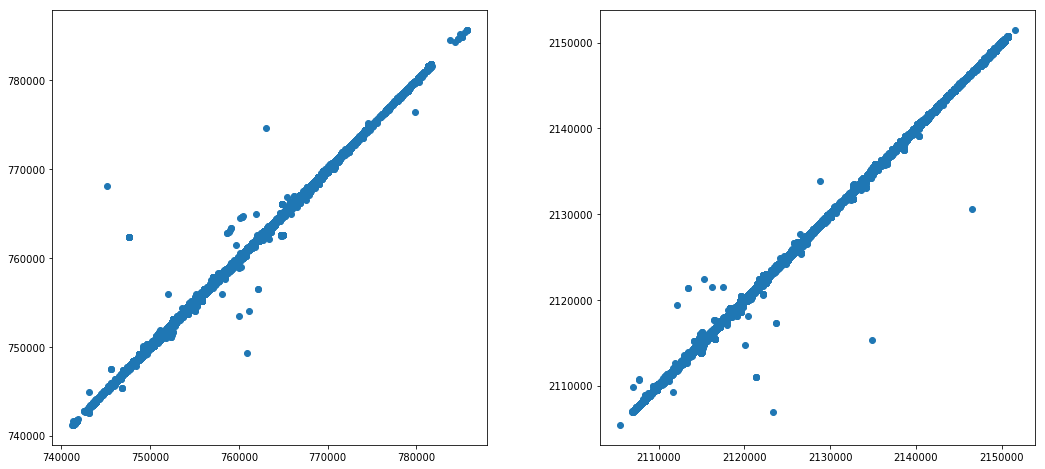

In [31]:
proj = pyproj.Proj({"init" : "epsg:2845"})
mask = np.asarray(pd.notnull(lon) & pd.notnull(xcs))
com_x, com_y = proj(lon[mask], lat[mask])

fig, ax = plt.subplots(ncols=2, figsize=(18,8))
ax[0].scatter(com_x, xcs[mask] * 1200/3937)
ax[1].scatter(com_y, ycs[mask] * 1200/3937)
for a in ax:
    a.set_aspect(1)

In [32]:
drift = gpd.GeoDataFrame()
drift["location"] = frame["Incident Address"][mask]
geo = []
for lo, la, x, y in zip(lon[mask], lat[mask], xcs[mask], ycs[mask]):
    xx, yy = proj(x * 1200 / 3937, y * 1200 / 3937, inverse=True)
    geo.append( shapely.geometry.LineString([[lo, la], [xx, yy]]) )
drift.geometry = geo
drift.crs = {"init":"epsg:4326"}

In [33]:
drift.head()

,location,geometry
0,5850 BELT LINE RD,"LINESTRING (-96.807131 32.953948, -96.80769738..."
1,4400 W DAVIS ST,"LINESTRING (-96.892956 32.749608, -96.89140034..."
2,600 E COLORADO BLVD,"LINESTRING (-96.81515400000001 32.758751, -96...."
3,2231 SINGLETON BLVD,"LINESTRING (-96.858248 32.778774, -96.85790517..."
4,400 CRESCENT CT,"LINESTRING (-96.80388000000001 32.794004, -96...."


In [34]:
drift.to_file("dallas_diff")

In [35]:
lonlat, xy = [], []
for lo, la, x, y in zip(lon[mask], lat[mask], xcs[mask], ycs[mask]):
    xx, yy = proj(x * 1200 / 3937, y * 1200 / 3937, inverse=True)
    lonlat.append(tilemapbase.project(lo,la))
    xy.append(tilemapbase.project(xx,yy))
lonlat = np.asarray(lonlat)
xy = np.asarray(xy)

lines = [[s,e] for s,e in zip(lonlat, xy)]

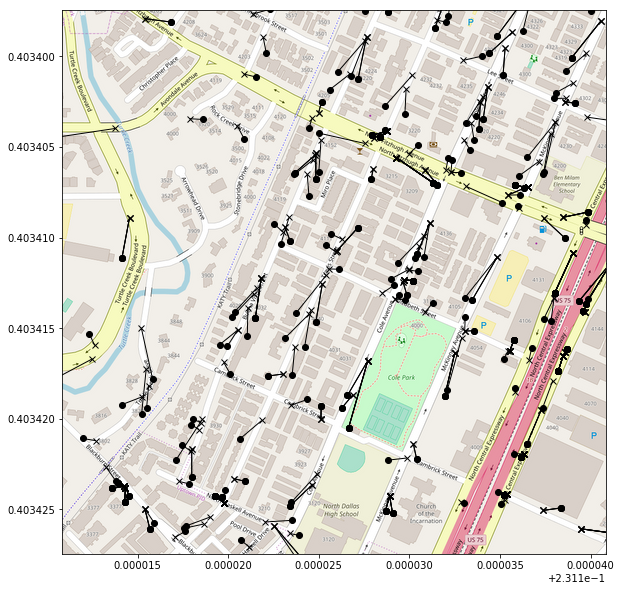

In [36]:
import matplotlib.collections
ex = tilemapbase.Extent.from_centre_lonlat(-96.7947, 32.8148, xsize=0.00003)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)

ax.scatter(*lonlat.T, marker="x", color="black", linewidth=1)
ax.scatter(*xy.T, marker="o", color="black", linewidth=1)
c = matplotlib.collections.LineCollection(lines, linewidth=1, color="black")
ax.add_collection(c)

What we see is that:

- The Longitude / Latitude coordinates seem to always fall in the middle of the road
- The "X/Y" coordinates seem to hit buildings, or otherwise be off roads.
- **This is misleading**.  By browsing around with QGIS, it becomes apparent that the Longitude / Latitude coordinates occur at the point of the road _outside the correct address_.
- That is, the offset given by X/Y Coordinates seems random, and is less geographically accurate.

Unfortunately, the data from after March 2017 _never_ has longitude and latitude data...

In [37]:
count = 0
last_call = None
for i, row in frame.iterrows():
    call = row["Call Date Time"]
    if call == "":
        continue
    call = datetime.datetime.strptime(call, "%m/%d/%Y %I:%M:%S %p")
    loc = row["Location1"].splitlines()
    if len(loc) < 3:
        count += 1
    else:
        if last_call is None or last_call < call:
            last_call = call
count, last_call

(62672, datetime.datetime(2017, 2, 7, 23, 18, 50))

In [38]:
sum(datetime.datetime.strptime(row["Call Date Time"], "%m/%d/%Y %I:%M:%S %p")
        > datetime.datetime(2017,3,1)
    for _, row in frame.iterrows() if row["Call Date Time"] != "" )

51098

In [39]:
last_call = None
for i, row in frame.iterrows():
    call = row["Call Date Time"]
    if call == "":
        continue
    call = datetime.datetime.strptime(call, "%m/%d/%Y %I:%M:%S %p")
    if row[" X Coordinate "] != "":
        if last_call is None or last_call < call:
            last_call = call
last_call

datetime.datetime(2017, 9, 11, 0, 24, 19)

## Conclusions about geo-coding

- Could use Lon/Lat data, but only for data before March 2017.  Gives the "correct" location, but always moved perpendicularly to the centre of the street.  (And so probably very misleading for appartment complexes etc.)
- Use the X/Y Coords, but in the knowledge that the location is a random perturbation of where it should be.

### Visualise in QGIS

In [40]:
xcs = frame[" X Coordinate "].map(safe_float)
ycs = frame[" Y Coordinate"].map(safe_float)
mask = pd.notnull(xcs)
xcs = xcs[mask].values * 1200 / 3937
ycs = ycs[mask].values * 1200 / 3937
xcs, ycs = proj(xcs, ycs, inverse=True)

In [41]:
out = gpd.GeoDataFrame({"Address" : frame["Incident Address"][mask],
                       "Call" : frame["Call Date Time"][mask],
                       "Crime" : frame["UCR Offense Description"][mask]
                       })
out.geometry = [shapely.geometry.Point(x,y) for x,y in zip(xcs, ycs)]
out.crs = {"init":"epsg:4326"}

In [42]:
out.head()

,Address,Call,Crime,geometry
0,5850 BELT LINE RD,11/18/2016 11:42:26 AM,BURGLARY,POINT (-96.80769738527677 32.95379870611899)
1,4400 W DAVIS ST,11/20/2016 12:50:30 AM,MOTOR VEHICLE ACCIDENT,POINT (-96.89140034070425 32.74944790723305)
2,600 E COLORADO BLVD,11/18/2016 11:28:52 PM,FOUND PROPERTY,POINT (-96.81563564356578 32.75859972894644)
3,2231 SINGLETON BLVD,11/18/2016 06:44:57 PM,ROBBERY,POINT (-96.85790517438581 32.77895836802691)
4,400 CRESCENT CT,11/19/2016 02:08:16 PM,THEFT,POINT (-96.80375110230122 32.79384180350985)


In [43]:
out.to_file("dallas")

# Use the library code

In [5]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..")))

In [6]:
import impute.dallas

In [7]:
data = list(impute.dallas.load(filename))
data_full = list(impute.dallas.load_full(filename))

In [8]:
data = {row.code : row for row in data}
data_full = {row.code : row for row in data_full}

In [9]:
assert len(data) == len(set(data.keys()))
assert len(data_full) == len(set(data_full.keys()))
assert set(data.keys()) == set(data_full.keys())

In [10]:
for code in data:
    row, row1 = data[code], data_full[code]
    assert data[code].crime_type == data_full[code].crime_type or data[code].crime_type == ""
    assert data[code].crime_subtype == data_full[code].crime_subtype or data[code].crime_subtype == ""
    assert row.start_time == row1.start_time or row.start_time is None
    assert row.end_time == row1.end_time or row.end_time is None
    assert row.call_time == row1.call_time or row.call_time is None
    assert row.address == row1.address or row.address == ""
    assert row.city == row1.city or row.city == ""
    assert row.lonlat == row1.lonlat or row.lonlat is None
    assert row.xy == row1.xy or row.xy is None

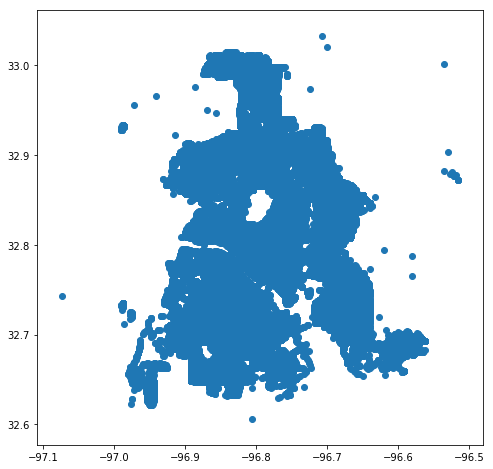

In [11]:
points = np.asarray([row.lonlat for row in data_full.values() if row.lonlat is not None])
points.shape

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*points.T)

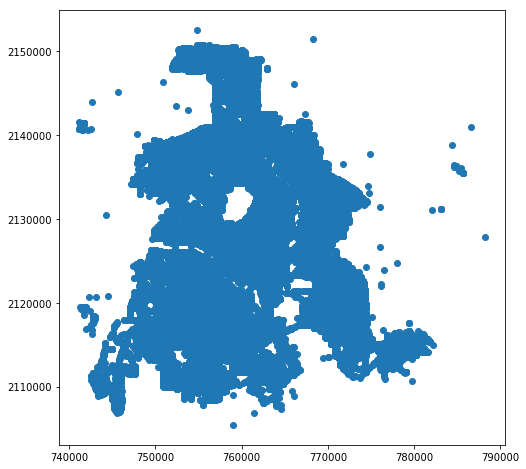

In [12]:
points = np.asarray([row.xy for row in data_full.values() if row.xy is not None])
points.shape

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(*points.T)

In [40]:
frame = impute.dallas.to_geoframe(filename)
frame.head()

,code,crime_type,crime_subtype,start_time,end_time,call_time,address,city,x,y,lon,lat,geometry
0,276285-2016,BURGLARY,BURGLARY-RESIDENCE,2016-11-16 11:00:00,2016-11-18 11:00:00,2016-11-18 11:42:26,5850 BELT LINE RD,DALLAS 75254,231101.872364,653493.706035,-96.807131,32.953948,POINT (231101.8723642642 653493.7060345256)
1,277474-2016,MOTOR VEHICLE ACCIDENT,ACCIDENT MV,2016-11-20 00:40:00,2016-11-20 00:45:00,2016-11-20 00:50:30,4400 W DAVIS ST,DALLAS 75211,228822.734527,646550.220798,-96.892956,32.749608,POINT (228822.7345272984 646550.2207975964)
2,276593-2016,FOUND PROPERTY,FOUND,2016-11-18 23:28:00,2016-11-18 23:28:00,2016-11-18 23:28:52,600 E COLORADO BLVD,DALLAS 75203,230981.469742,646893.413264,-96.815154,32.758751,POINT (230981.4697415552 646893.4132635808)
3,276430-2016,ROBBERY,ROBBERY-BUSINESS,2016-11-18 18:32:00,2016-11-18 18:32:00,2016-11-18 18:44:57,2231 SINGLETON BLVD,DALLAS 75212,229763.705344,647562.311509,-96.858248,32.778774,POINT (229763.7053437693 647562.3115085037)
4,277049-2016,THEFT,OTHER THEFTS,2016-11-18 01:30:00,2016-11-18 07:30:00,2016-11-19 14:08:16,400 CRESCENT CT,DALLAS 75201,231301.600446,648089.852187,-96.803880,32.794004,POINT (231301.600446244 648089.8521874177)


In [41]:
mask = frame.x.isnull().values
m = ~frame.lon.isnull().values & mask
np.sum(m)

1191

In [49]:
f = frame[m].copy()
f.geometry = [shapely.geometry.Point(x,y) for x,y in zip(f.lon, f.lat)]
f.crs = {"init":"epsg:4326"}
f.start_time = f.start_time.map(str)
f.end_time = f.end_time.map(str)
f.call_time = f.call_time.map(str)
f.head()

,code,crime_type,crime_subtype,start_time,end_time,call_time,address,city,x,y,lon,lat,geometry
69,276331-2016,BURGLARY,BURGLARY-RESIDENCE,2016-11-18 16:40:00,2016-11-18 16:44:00,2016-11-18 16:38:31,5034 EAST RIM RD,DALLAS 75211,NaN,NaN,-96.912981,32.728901,POINT (-96.912981 32.728901)
170,277089-2016,LOST PROPERTY,LOST,2016-11-19 15:10:00,2016-11-19 15:15:00,2016-11-19 15:33:13,9378 N CENTRAL SERV E,DALLAS 75231,NaN,NaN,-96.769745,32.875977,POINT (-96.769745 32.875977)
171,275953-2015,ASSAULT,ASSAULT,2015-11-27 11:30:00,2015-11-27 11:30:00,2015-11-27 11:29:13,5031 CLOVER HAVEN,DALLAS 75227,NaN,NaN,-96.689423,32.786485,POINT (-96.68942300000001 32.786485)
228,278729-2016,THEFT,OTHER THEFTS,2016-11-21 18:54:00,2016-11-21 18:59:00,2016-11-21 15:13:21,8687 N CENTRAL SERV W,DALLAS 75225,NaN,NaN,-96.770691,32.868750,POINT (-96.770691 32.86875)
229,277972-2015,MOTOR VEHICLE ACCIDENT,ACCIDENT MV,2015-11-30 06:18:00,2015-11-30 06:28:00,2015-11-30 06:17:59,10300 N CENTRAL SERV E,DALLAS 75231,NaN,NaN,-96.769680,32.885836,POINT (-96.76967999999999 32.885836)


In [50]:
f.to_file("dalls_odd")